In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def corr(trace):
    """ calculate the autocorrelation of a trace of scalar data
    pre:  trace should be a 1D iterable array of floating point numbers
    post: return the autocorrelation of this trace of scalars
    """

    mu     = np.mean(trace)
    stddev = np.std(trace,ddof=1)

    correlation_time = 0.
    for k in range(1,len(trace)):
        # calculate auto_correlation
        auto_correlation = 0.0
        num = len(trace)-k
        for i in range(num):
            auto_correlation += (trace[i]-mu)*(trace[i+k]-mu)
        # end for i
        auto_correlation *= 1.0/(num*stddev**2)
        if auto_correlation > 0:
            correlation_time += auto_correlation
        else:
            break
        # end if
    # end for k

    correlation_time = 1.0 + 2.0*correlation_time
    return correlation_time

# end def corr

def binormal(x,rho):
    x1,x2 = x
    z = x1*x1-2*rho*x1*x2+x2*x2
    return np.exp( -z/(2*(1-rho)) )
# end def

def metropolis_bivariate_std_normal(rho,nsample,sig=0.5):
    # initialize
    sample0 = (0,0)
    samples = np.zeros([nsample,2])
    samples[0,:] = sample0
    
    # sample
    naccept = 0
    for isample in range(1,nsample):
        prev = samples[isample-1,:]
        proposal = prev + sig*np.random.randn(2)
        
        prob = binormal(proposal,rho)/binormal(prev,rho)
        if np.random.rand() < prob:
            samples[isample,:] = proposal
            naccept += 1
        else:
            samples[isample,:] = prev
        # end if
    # end for isample
    print 'MH acceptance: {rate:d}%'.format(
        rate=int(round( 100*float(naccept)/nsample )) 
    )
    return samples
# end def metropolis_bivariate_std_normal

def gibbs_bivariate_std_normal(rho,nsample):
    sample0 = (0,0)
    samples = np.zeros([2*nsample,2])
    samples[0,:] = sample0
    for isample in range(1,nsample):
        # start with previous sample
        samples[2*isample,:] = samples[2*isample-1,:]
        # resample first element
        samples[2*isample,0] = np.sqrt(1-rho*rho)*np.random.randn() + rho*samples[2*isample-1,1]
        
        # start with previous sample
        samples[2*isample+1,:] = samples[2*isample,:]
        # resample second element
        samples[2*isample+1,1] = np.sqrt(1-rho*rho)*np.random.randn() + rho*samples[2*isample,0]
    # end for isample
    return samples
# end def

In [3]:
rho = 0.7
nsample = 1000
sig = 0.5

msamples = metropolis_bivariate_std_normal(rho,nsample,sig=sig)
gsamples = gibbs_bivariate_std_normal(rho,nsample)
npsamples= np.random.multivariate_normal([0,0],[[1,rho],[rho,1]],nsample)

mkappa = corr(msamples[:,0])
gkappa = corr(msamples[::2,0])
npkappa= corr(npsamples[:,0])
print 'sample correlation:'
print 'MH     Gibbs   numpy'
print '{mh:5.2f}  {gibbs:5.2f}  {np:5.2f}'.format(
    mh = mkappa,
    gibbs = gkappa,
    np = npkappa
)

MH acceptance: 59%
sample correlation:
MH     Gibbs   numpy
35.60  18.27   1.00


In [4]:
from matplotlib.path import Path
import matplotlib.patches as patches
def plot_samples(ax,samples,npath=10,alpha=0.3):
    
    myx,myy = samples.T
    
    path = Path(samples[:npath])
    patch = patches.PathPatch(path,color='r',fill=False,capstyle='butt', lw=2)
    
    ax.scatter(myx,myy,marker='.',alpha=alpha)
    ax.add_patch(patch)
    
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    
    ax.set_xlim(-3,3)
    ax.set_ylim(-3,3)
    
# end def plot_samples

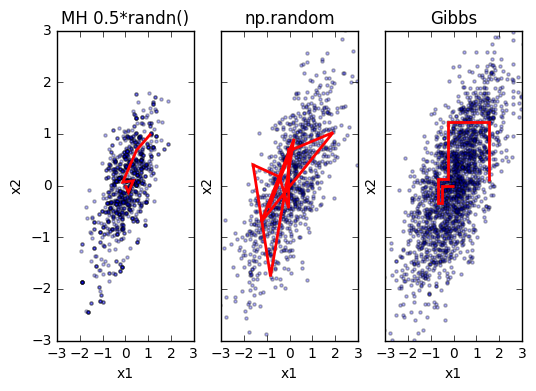

In [5]:
# no thinning/blocking
# notice equilibration and correlation issues with MH
fig,ax = plt.subplots(1,3,sharey=True)
ax[0].set_title('MH %2.1f*randn()' % sig)
ax[1].set_title('np.random')
ax[2].set_title('Gibbs')

mh_thinning = 1
gibbs_thinning = 1

plot_samples(ax[0],msamples[::mh_thinning])
plot_samples(ax[1],npsamples)
plot_samples(ax[2],gsamples[::gibbs_thinning])

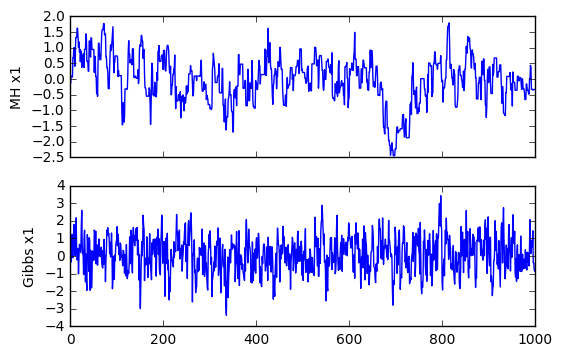

In [7]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].set_ylabel('MH x1')
ax[1].set_ylabel('Gibbs x1')

ax[0].plot(msamples[:,1])
ax[1].plot(gsamples[::2,1])
#fig.savefig('traces.png',dpi=200)

samples from Gibbs:  56
samples from MH:  28


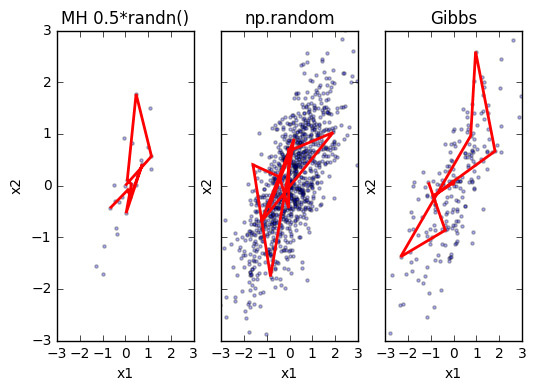

In [9]:
# with thinning
# Gibbs gets more samples than MH
fig,ax = plt.subplots(1,3,sharey=True)
ax[0].set_title('MH %2.1f*randn()' % sig)
ax[1].set_title('np.random')
ax[2].set_title('Gibbs')

mh_thinning = int(round(mkappa))
gibbs_thinning = int(round(gkappa))

plot_samples(ax[0],msamples[::mh_thinning])
plot_samples(ax[1],npsamples)
plot_samples(ax[2],gsamples[::10])

ngibbs = len(gsamples[::gibbs_thinning])/2
nmh = len(msamples[::mh_thinning])
print 'samples from Gibbs: ',ngibbs
print 'samples from MH: ',nmh

In [10]:
nsample = 10000
nrho = 20
rhos = np.linspace(0,0.95,nrho)
gcorrs= np.zeros(nrho)
mcorrs= np.zeros(nrho)
for irho in range(nrho):
    rho = rhos[irho]
    
    my_samples = gibbs_bivariate_std_normal(rho,nsample)
    myx,myy = my_samples.T
    gcorrs[irho] = corr(myx[::2])
    
    my_samples = metropolis_bivariate_std_normal(rho,nsample)
    myx,myy = my_samples.T
    mcorrs[irho] = corr(myx)
# end for

MH acceptance: 76%
MH acceptance: 76%
MH acceptance: 75%
MH acceptance: 74%
MH acceptance: 73%
MH acceptance: 73%
MH acceptance: 72%
MH acceptance: 70%
MH acceptance: 70%
MH acceptance: 68%
MH acceptance: 68%
MH acceptance: 66%
MH acceptance: 64%
MH acceptance: 63%
MH acceptance: 60%
MH acceptance: 57%
MH acceptance: 55%
MH acceptance: 49%
MH acceptance: 43%
MH acceptance: 33%


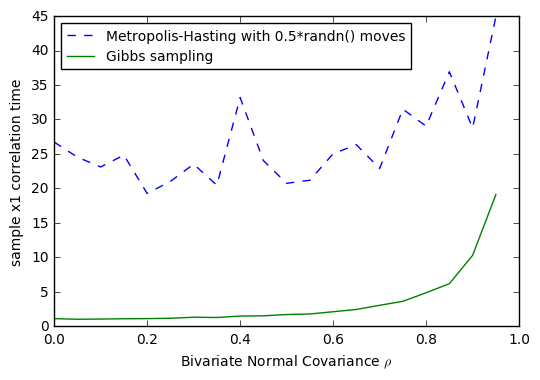

In [12]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel(r'Bivariate Normal Covariance $\rho$')
ax.set_ylabel('sample x1 correlation time')

ax.plot(rhos,mcorrs,'--',label='Metropolis-Hasting with 0.5*randn() moves')
ax.plot(rhos,gcorrs,'-',label='Gibbs sampling')

ax.legend(fontsize=10,loc='upper left')
#fig.savefig('correlation.png',dpi=200)